In [1]:
!pip install  pyDVL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.3 MB/s eta 0:00:00


In [2]:
import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.utils import *
from src.dataloader import *
from triage.triage import Triage

### Helper

In [3]:
def evaluate_methods(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    from sklearn.linear_model import  LinearRegression

    results = {}
    results_mse = {}

    ######
    myids = we_ids
    keep = len(myids)

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids,:], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results['TRIAGE'] = reg_metric(y_test, y_pred)
    results_mse['TRIAGE'] = reg_metric_mse(y_test, y_pred)


    return results, results_mse

### Data Valuation

In [6]:
from pydvl.value import *
from pydvl.utils import Dataset

def evaluate_dv(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed, method = 'shap', n_keep=100):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    from sklearn.linear_model import  LinearRegression
    import xgboost as xgb

    train_ids = random.sample(list(range(len(y_prop_train))),int(1*len(y_prop_train)))
    y_prop_train = y_prop_train[train_ids]
    X_prop_train = X_prop_train[train_ids,:]


    X_prop_train = np.array(X_prop_train)
    y_prop_train = np.array(y_prop_train)
    X_cal = np.array(X_cal)
    y_cal = np.array(y_cal)

    dataset = Dataset(X_prop_train, y_prop_train, X_cal, y_cal)

    model = xgb.XGBRegressor(n_estimators=10, random_state=seed)
    utility = Utility(
        model=model,
        data=dataset,
        scorer=Scorer("neg_mean_absolute_error", default=0.0),
    )



    values = compute_shapley_values(
              utility,
              mode=ShapleyMode.TruncatedMontecarlo,
              # Stop if the standard error is below 1% of the range of the values (which is ~2),
              # or if the number of updates exceeds 1000
              done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
              n_jobs=-1,
          )

    myids = we_ids
    keep = n_keep

    values.sort(key="value")
    keeplow = values.indices[0:keep]
    keephigh = values.indices[-keep:]

    results = {}
    results_mse = {}
    print('DV...')
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[keeplow,:], y_prop_train[keeplow])
    y_pred = learner_prop.predict(X_test)
    results[f'{method}_low'] = reg_metric(y_test, y_pred)
    results_mse[f'{method}_low'] = reg_metric_mse(y_test, y_pred)

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[keephigh,:], y_prop_train[keephigh])
    y_pred = learner_prop.predict(X_test)
    results[f'{method}_high'] = reg_metric(y_test, y_pred)
    results_mse[f'{method}_high'] = reg_metric_mse(y_test, y_pred)

    return results, results_mse

### Computation

In [7]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt #for plotting

from tqdm import tqdm

from copy import deepcopy
import random
import time
import xgboost as xgb
from tqdm import tqdm
full_results = {}
full_results_mse = {}

full_shap_results = {}
full_shap_results_mse = {}


cal_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3,  0.4,0.5]
n_runs = 1

full_triage_time = {}
full_shap_time = {}
for cal_size in tqdm(cal_list):
    print("--------------------------------")
    print(f"Running cal size = {cal_size}")
    print("--------------------------------")
    final_results = []
    final_results_mse = []

    final_shap_results = []
    final_shap_results_mse = []


    triage_time = []
    shap_time = []
    for i in range(n_runs):

        seed = i *10
        random.seed(seed)

        X_prop_train, y_prop_train, _ = load_seer_cutract_dataset(name="seer", seed=seed)
        train_ids = random.sample(list(range(len(y_prop_train))),int(0.2*len(y_prop_train)))
        y_prop_train = y_prop_train[train_ids]
        X_prop_train = X_prop_train.iloc[train_ids,:]

        X_prop_train = X_prop_train.reset_index(drop=True)
        y_prop_train = y_prop_train.reset_index(drop=True)

        min_y = y_prop_train.min()
        max_y = y_prop_train.max()

        y_prop_train = np.array([(y_prop_train[i]-min_y)/(max_y-min_y) for i in range(len(y_prop_train))])
        y_prop_train = pd.Series(y_prop_train)

        X_eval, y_eval, _ = load_seer_cutract_dataset(name="cutract", seed=seed)

        y_eval = np.array([(y_eval[i]-min_y)/(max_y-min_y) for i in range(len(y_eval))])
        y_eval = pd.Series(y_eval)

        test_ids = random.sample(list(range(len(y_eval))),int(0.5*len(y_eval)))

        X_test, y_test = X_eval.iloc[test_ids,:], y_eval.iloc[test_ids]

        remaining_eval_ids = np.setdiff1d(range(len(y_eval)), test_ids)

        _, X_cal, _, y_cal = train_test_split(X_eval.iloc[remaining_eval_ids,:],
                                              y_eval.iloc[remaining_eval_ids],
                                              test_size=cal_size,
                                             random_state=seed)

        X_prop_train, X_cal, X_test = np.array(X_prop_train), np.array(X_cal), np.array(X_test)
        y_prop_train, y_cal, y_test = np.array(y_prop_train), np.array(y_cal), np.array(y_test)

        prop = 0.1
        num_ids = int(prop*len(y_prop_train))
        last_ids = range(len(y_prop_train))
        y_prop_train_corrupt = deepcopy(y_prop_train)
        corruptids = random.sample(list(last_ids),num_ids)
        for myid in corruptids:
            corruption = (np.random.choice(5, 1)[0]/2)+1
            y_prop_train_corrupt[myid] = y_prop_train_corrupt[myid]*corruption

        start = time.time()

        nest = 10
        learner = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
        learner.fit(X_prop_train, y_prop_train)

        y_eval = y_prop_train
        X_eval = X_prop_train

        triage = Triage(X_eval = X_eval, y_eval = y_eval, X_cal=X_cal, y_cal=y_cal, nest=nest, learner=learner)
        groups_ids, raw_metrics = triage.run()

        triage_array = raw_metrics['score_metric']

        percentile_thresh = 75
        thresh = 0.33
        conf_thresh_low = thresh
        conf_thresh_high = 1 - thresh
        conf_thresh = 0.5

        variability=  np.std(triage_array, axis=-1) 
        confidence = np.mean(triage_array, axis=-1)

        uncert_percentile = np.percentile(variability, percentile_thresh)


        oe_ids = np.where(
            (confidence <= conf_thresh_low)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]
        ue_ids = np.where(
            (confidence >= conf_thresh_high)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]

        other_ids = np.concatenate((oe_ids, ue_ids))
        we_ids = []
        for id in range(len(confidence)):
            if id not in other_ids:
                we_ids.append(id)

        we_ids = np.array(we_ids)

        end = time.time()
        duration_triage = end-start

        n_keep = len(we_ids)


        results, results_mse = evaluate_methods(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed)
        final_results.append(results)
        final_results_mse.append(results_mse)

        print('running shap...')
        start_shap = time.time()
        results, results_mse = evaluate_dv(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed,  method = 'shap', n_keep = n_keep)
        end_shap = time.time()
        duration_shap = end_shap-start_shap
        final_shap_results.append(results)
        final_shap_results_mse.append(results_mse)

        triage_time.append(duration_triage)
        shap_time.append(duration_shap)

    full_results[cal_size] = final_results
    full_results_mse[cal_size] = final_results_mse

    full_shap_results[cal_size] = final_shap_results
    full_shap_results_mse[cal_size] = final_shap_results_mse

    full_triage_time[cal_size] = triage_time
    full_shap_time[cal_size] = shap_time

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.01
--------------------------------


running shap...


 10%|█         | 1/10 [49:26<7:24:58, 2966.50s/it]

2326 2326
DV...
--------------------------------
Running cal size = 0.02
--------------------------------


running shap...


 20%|██        | 2/10 [1:38:56<6:35:46, 2968.27s/it]

2042 2042
DV...
--------------------------------
Running cal size = 0.03
--------------------------------


running shap...


 30%|███       | 3/10 [2:29:09<5:48:42, 2988.89s/it]

2290 2290
DV...
--------------------------------
Running cal size = 0.04
--------------------------------


running shap...


 40%|████      | 4/10 [3:20:02<5:01:24, 3014.06s/it]

1771 1771
DV...
--------------------------------
Running cal size = 0.05
--------------------------------


running shap...


 50%|█████     | 5/10 [4:08:50<4:08:36, 2983.34s/it]

1608 1608
DV...
--------------------------------
Running cal size = 0.1
--------------------------------


running shap...


 60%|██████    | 6/10 [4:58:35<3:18:55, 2983.79s/it]

1535 1535
DV...
--------------------------------
Running cal size = 0.2
--------------------------------


running shap...


 70%|███████   | 7/10 [5:48:49<2:29:40, 2993.66s/it]

1720 1720
DV...
--------------------------------
Running cal size = 0.3
--------------------------------


running shap...


 80%|████████  | 8/10 [6:40:15<1:40:46, 3023.02s/it]

1552 1552
DV...
--------------------------------
Running cal size = 0.4
--------------------------------


running shap...


 90%|█████████ | 9/10 [7:29:27<50:00, 3000.95s/it]  

1678 1678
DV...
--------------------------------
Running cal size = 0.5
--------------------------------


running shap...


100%|██████████| 10/10 [8:19:51<00:00, 2999.18s/it]

1641 1641
DV...


In [ ]:
full_shap_results_mse


{0.01: [{'shap_low': 0.25830538095777283, 'shap_high': 0.05820445305911615}],
 0.02: [{'shap_low': 0.2560501944752939, 'shap_high': 0.04419557922129634}],
 0.03: [{'shap_low': 0.18012991135476314, 'shap_high': 0.048918378598371386}],
 0.04: [{'shap_low': 0.19161819635761165, 'shap_high': 0.047215495272554}],
 0.05: [{'shap_low': 0.13740048306995936, 'shap_high': 0.05887530064544275}],
 0.1: [{'shap_low': 0.18396199151013762, 'shap_high': 0.04903900877714909}],
 0.2: [{'shap_low': 0.2006245254071296, 'shap_high': 0.050147807313831845}],
 0.3: [{'shap_low': 0.198692523785574, 'shap_high': 0.046094434142690335}],
 0.4: [{'shap_low': 0.2060695989653049, 'shap_high': 0.046892775629188733}],
 0.5: [{'shap_low': 0.18719929845477792, 'shap_high': 0.04574203787643775}]}

In [ ]:
triage_duration = {0.01: [13.592303276062012,
  12.11628794670105,
  13.839148044586182,
  7.2357964515686035,
  7.930066823959351],
 0.02: [5.309587001800537,
  5.600575923919678,
  5.958172559738159,
  7.330204248428345,
  8.375477075576782],
 0.03: [5.5242791175842285,
  5.388054132461548,
  7.5029497146606445,
  7.681819438934326,
  5.231717824935913],
 0.04: [5.566140651702881,
  7.413840055465698,
  6.305266857147217,
  5.485929250717163,
  6.827686309814453],
 0.05: [8.259703397750854,
  5.459472417831421,
  6.584894180297852,
  8.091211080551147,
  5.449443101882935],
 0.1: [7.168504476547241,
  5.731634616851807,
  7.736143112182617,
  5.730257272720337,
  7.9520580768585205],
 0.2: [7.778499126434326,
  8.21269178390503,
  8.37436580657959,
  9.002830266952515,
  6.270653963088989],
 0.3: [6.816506624221802,
  6.731396913528442,
  8.901012182235718,
  9.637054920196533,
  6.678992986679077],
 0.4: [7.619242906570435,
  9.112505197525024,
  9.649351119995117,
  8.042877674102783,
  7.815609455108643],
 0.5: [9.616340637207031,
  9.351863384246826,
  7.819536447525024,
  7.7934441566467285,
  7.8859429359436035]}

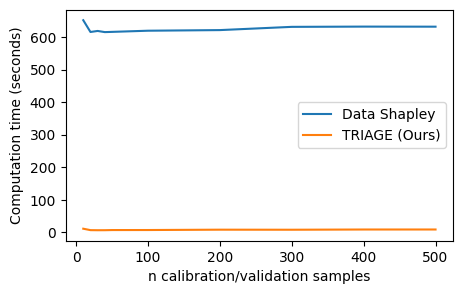

In [ ]:
import matplotlib.pyplot as plt

triage1 = [full_triage_time[key] for key in full_triage_time.keys()]
shap = [full_shap_time[key] for key in full_shap_time.keys()]
triage2 = [np.mean(triage_duration[key]) for key in triage_duration.keys()]

plt.figure(figsize=(5,3))
plt.plot(np.array(list(full_triage_time.keys()))*1000, shap, label= 'Data Shapley')
plt.plot(np.array(list(full_triage_time.keys()))*1000, triage2, label= 'TRIAGE (Ours)')
plt.xlabel('n calibration/validation samples')
plt.ylabel('Computation time (seconds)')
plt.legend()
plt.savefig('time_data_shap_small.pdf', bbox_inches="tight")
